In [1]:
from pathlib import Path
import random
import json
import shutil
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm

In [2]:

SRC_DIR = Path("data/MangoAugmented")
OUT_DIR = Path("data/MangoAugmented_split")
SPLIT_META_PATH = OUT_DIR / "splits.json"

RANDOM_SEED = 42
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}

In [3]:


def gather_images():
    classes = []
    images_by_class = {}

    for class_dir in sorted(p for p in SRC_DIR.iterdir() if p.is_dir()):
        class_name = class_dir.name
        classes.append(class_name)
        images = []
        for ext in IMG_EXTS:
            images.extend(class_dir.rglob(f"*{ext}"))
        # In case of weird case sensitivity or non-image files
        images = [p for p in images if p.suffix.lower() in IMG_EXTS]
        if not images:
            print(f"[WARN] No images found for class '{class_name}'")
        images_by_class[class_name] = images

    return classes, images_by_class


def make_splits(classes, images_by_class):
    random.seed(RANDOM_SEED)
    splits = {"train": {}, "val": {}, "test": {}}
    for cls in classes:
        paths = list(images_by_class[cls])
        random.shuffle(paths)
        n = len(paths)
        n_train = int(n * TRAIN_RATIO)
        n_val = int(n * VAL_RATIO)
        # ensure all go somewhere
        n_test = n - n_train - n_val

        splits["train"][cls] = paths[:n_train]
        splits["val"][cls] = paths[n_train:n_train + n_val]
        splits["test"][cls] = paths[n_train + n_val:]

    return splits


def copy_one(args):
    src, dst = args
    dst.parent.mkdir(parents=True, exist_ok=True)
    shutil.copy2(src, dst)
    return str(dst)


In [4]:

OUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"[INFO] Scanning source directory: {SRC_DIR}")
classes, images_by_class = gather_images()
num_classes = len(classes)
print(f"[INFO] Found {num_classes} classes: {classes}")

splits = make_splits(classes, images_by_class)

# Build copy tasks
copy_tasks = []
for split_name, split_dict in splits.items():
    for cls, paths in split_dict.items():
        for src in paths:
            rel_name = src.name
            dst = OUT_DIR / split_name / cls / rel_name
            copy_tasks.append((src, dst))

print(f"[INFO] Total images to copy: {len(copy_tasks)}")
if not copy_tasks:
    print("[WARN] No images to copy. Exiting.")


# Copy with multiprocessing + tqdm
with ProcessPoolExecutor() as ex:
    list(tqdm(ex.map(copy_one, copy_tasks), total=len(copy_tasks), desc="Copying images"))

# Build simple metadata
meta = {
    "src_dir": str(SRC_DIR),
    "out_dir": str(OUT_DIR),
    "num_classes": num_classes,
    "classes": classes,
    "splits_counts": {
        split_name: {cls: len(paths) for cls, paths in split_dict.items()}
        for split_name, split_dict in splits.items()
    },
    "ratios": {
        "train": TRAIN_RATIO,
        "val": VAL_RATIO,
        "test": TEST_RATIO,
    },
    "random_seed": RANDOM_SEED,
}

with SPLIT_META_PATH.open("w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2)

print(f"[INFO] Saved split metadata to {SPLIT_META_PATH}")


[INFO] Scanning source directory: data/MangoAugmented
[INFO] Found 15 classes: ['Amrapali', 'Ashshina Classic', 'Ashshina Zhinuk', 'Banana Mango', 'Bari-11', 'Bari-4', 'Fazli Classic', 'Fazli Shurmai', 'Gourmoti', 'Harivanga', 'Himsagor', 'Katimon', 'Langra', 'Rupali', 'Shada']
[INFO] Total images to copy: 17109


Copying images: 100%|██████████| 17109/17109 [00:00<00:00, 18632.30it/s]

[INFO] Saved split metadata to data/MangoAugmented_split/splits.json


In [5]:
from pathlib import Path
import os
import csv
from dataclasses import dataclass, asdict
from typing import Dict, List

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

In [6]:

DATA_ROOT = Path("data/MangoAugmented_split")
RESULTS_DIR = Path("results")
CHECKPOINT_DIR = RESULTS_DIR / "checkpoints"
PLOTS_DIR = RESULTS_DIR / "plots"

IMG_SIZE = 256
BATCH_SIZE = 8
EPOCHS = 20
LR = 1e-3

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_WORKERS = max(1, os.cpu_count() // 2)

RESULTS_DIR.mkdir(parents=True, exist_ok=True)
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

In [7]:

class CustomCNN(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 128 x 128

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 64 x 64

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 32 x 32

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 16 x 16
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * (IMG_SIZE // 16) * (IMG_SIZE // 16), 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [8]:

def compute_confusion_matrix(preds: torch.Tensor, targets: torch.Tensor, num_classes: int) -> torch.Tensor:
    cm = torch.zeros(num_classes, num_classes, dtype=torch.int64, device=targets.device)
    for t, p in zip(targets.view(-1), preds.view(-1)):
        cm[t.long(), p.long()] += 1
    return cm


def compute_metrics_from_cm(cm: torch.Tensor) -> Dict[str, float]:
    eps = 1e-8
    tp_per_class = torch.diag(cm)
    tp = tp_per_class.sum().item()
    fp = (cm.sum(dim=0) - tp_per_class).sum().item()
    fn = (cm.sum(dim=1) - tp_per_class).sum().item()
    tn = (cm.sum() - cm.sum(dim=0) - cm.sum(dim=1) + tp_per_class).sum().item()

    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    f1 = 2 * precision * recall / (precision + recall + eps) if (precision + recall) > 0 else 0.0
    acc = tp / (tp + fn + fp + tn + eps)

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "tp": tp,
        "tn": tn,
        "fp": fp,
        "fn": fn,
    }


@dataclass
class BatchMetrics:
    epoch: int
    split: str
    batch_idx: int
    loss: float
    accuracy: float
    precision: float
    recall: float
    f1: float
    tp: float
    tn: float
    fp: float
    fn: float


def get_dataloaders():
    # standard ImageNet mean/std – fine for generic images
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    train_tfms = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
    val_tfms = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

    train_dir = DATA_ROOT / "train"
    val_dir = DATA_ROOT / "val"

    train_ds = datasets.ImageFolder(train_dir, transform=train_tfms)
    val_ds = datasets.ImageFolder(val_dir, transform=val_tfms)

    train_loader = DataLoader(
        train_ds,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )
    val_loader = DataLoader(
        val_ds,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )

    return train_loader, val_loader, train_ds.classes, mean, std


In [9]:
history = {"train": [], "val": []}
def train():
    train_loader, val_loader, class_names, mean, std = get_dataloaders()
    num_classes = len(class_names)
    model = CustomCNN(num_classes=num_classes).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    metrics_csv_path = RESULTS_DIR / "metrics.csv"
    csv_fieldnames = [
        "epoch", "split", "batch_idx", "loss",
        "accuracy", "precision", "recall", "f1", "tp", "tn", "fp", "fn",
    ]
    csv_file = metrics_csv_path.open("w", newline="", encoding="utf-8")
    csv_writer = csv.DictWriter(csv_file, fieldnames=csv_fieldnames)
    csv_writer.writeheader()

    best_val_f1 = 0.0

    # For plotting per-epoch curves

    for epoch in range(1, EPOCHS + 1):
        # --- Train ---
        model.train()
        train_loss_sum = 0.0
        train_cm_total = torch.zeros(num_classes, num_classes, dtype=torch.int64, device=DEVICE)
        train_samples = 0

        pbar = tqdm(
            enumerate(train_loader),
            total=len(train_loader),
            desc=f"Epoch {epoch}/{EPOCHS} [train]"
        )
        for batch_idx, (images, targets) in pbar:
            images, targets = images.to(DEVICE), targets.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                preds = outputs.argmax(dim=1)
                cm = compute_confusion_matrix(preds, targets, num_classes)
                train_cm_total += cm
                batch_metrics = compute_metrics_from_cm(cm)

            batch_size = targets.size(0)
            train_loss_sum += loss.item() * batch_size
            train_samples += batch_size

            # Log per-batch metrics
            row = BatchMetrics(
                epoch=epoch,
                split="train",
                batch_idx=batch_idx,
                loss=loss.item(),
                accuracy=batch_metrics["accuracy"],
                precision=batch_metrics["precision"],
                recall=batch_metrics["recall"],
                f1=batch_metrics["f1"],
                tp=batch_metrics["tp"],
                tn=batch_metrics["tn"],
                fp=batch_metrics["fp"],
                fn=batch_metrics["fn"],
            )
            csv_writer.writerow(asdict(row))

            # Update tqdm
            avg_loss = train_loss_sum / train_samples
            full_metrics = compute_metrics_from_cm(train_cm_total)
            pbar.set_postfix({
                "loss": f"{avg_loss:.4f}",
                "acc": f"{full_metrics['accuracy']:.4f}",
                "f1": f"{full_metrics['f1']:.4f}",
            })

        train_epoch_metrics = compute_metrics_from_cm(train_cm_total)
        train_epoch_loss = train_loss_sum / train_samples
        history["train"].append({
            "epoch": epoch,
            "loss": train_epoch_loss,
            **train_epoch_metrics,
        })

        # --- Val ---
        model.eval()
        val_loss_sum = 0.0
        val_cm_total = torch.zeros(num_classes, num_classes, dtype=torch.int64, device=DEVICE)
        val_samples = 0

        pbar = tqdm(
            enumerate(val_loader),
            total=len(val_loader),
            desc=f"Epoch {epoch}/{EPOCHS} [val]"
        )
        with torch.no_grad():
            for batch_idx, (images, targets) in pbar:
                images, targets = images.to(DEVICE), targets.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, targets)

                preds = outputs.argmax(dim=1)
                cm = compute_confusion_matrix(preds, targets, num_classes)
                val_cm_total += cm

                batch_size = targets.size(0)
                val_loss_sum += loss.item() * batch_size
                val_samples += batch_size

                batch_metrics = compute_metrics_from_cm(cm)
                row = BatchMetrics(
                    epoch=epoch,
                    split="val",
                    batch_idx=batch_idx,
                    loss=loss.item(),
                    accuracy=batch_metrics["accuracy"],
                    precision=batch_metrics["precision"],
                    recall=batch_metrics["recall"],
                    f1=batch_metrics["f1"],
                    tp=batch_metrics["tp"],
                    tn=batch_metrics["tn"],
                    fp=batch_metrics["fp"],
                    fn=batch_metrics["fn"],
                )
                csv_writer.writerow(asdict(row))

                avg_loss = val_loss_sum / val_samples
                full_metrics = compute_metrics_from_cm(val_cm_total)
                pbar.set_postfix({
                    "loss": f"{avg_loss:.4f}",
                    "acc": f"{full_metrics['accuracy']:.4f}",
                    "f1": f"{full_metrics['f1']:.4f}",
                })

        val_epoch_metrics = compute_metrics_from_cm(val_cm_total)
        val_epoch_loss = val_loss_sum / val_samples
        history["val"].append({
            "epoch": epoch,
            "loss": val_epoch_loss,
            **val_epoch_metrics,
        })

        # --- Checkpoints ---
        state = {
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "best_val_f1": best_val_f1,
            "class_names": class_names,
            "mean": mean,
            "std": std,
        }
        torch.save(state, CHECKPOINT_DIR / "last.pt")

        if val_epoch_metrics["f1"] > best_val_f1:
            best_val_f1 = val_epoch_metrics["f1"]
            torch.save(state, CHECKPOINT_DIR / "best.pt")
            print(f"[INFO] New best model at epoch {epoch} with val F1={best_val_f1:.4f}")

    csv_file.close()
    print(f"[INFO] Saved batch metrics CSV to {metrics_csv_path}")


In [10]:


def plot_epoch_curves(history: Dict[str, List[Dict]]):
    metrics_to_plot = ["loss", "accuracy", "precision", "recall", "f1"]
    epochs = [h["epoch"] for h in history["train"]]

    for metric in metrics_to_plot:
        plt.figure()
        train_vals = [h[metric] for h in history["train"]]
        val_vals = [h[metric] for h in history["val"]]
        plt.plot(epochs, train_vals, marker="o", label=f"train_{metric}")
        plt.plot(epochs, val_vals, marker="o", label=f"val_{metric}")
        plt.xlabel("Epoch")
        plt.ylabel(metric)
        plt.title(metric)
        plt.legend()
        plt.grid(True)
        out_path = PLOTS_DIR / f"{metric}_curve.png"
        plt.savefig(out_path, bbox_inches="tight")
        plt.show()
        print(f"[INFO] Saved {metric} curve to {out_path}")


In [11]:
train()

Epoch 1/20 [val]: 100%|██████████| 320/320 [00:01<00:00, 167.70it/s, loss=0.7292, acc=0.0502, f1=0.7525]


[INFO] New best model at epoch 1 with val F1=0.7525


Epoch 2/20 [val]: 100%|██████████| 320/320 [00:01<00:00, 183.44it/s, loss=0.5635, acc=0.0541, f1=0.8112]


[INFO] New best model at epoch 2 with val F1=0.8112


Epoch 3/20 [val]: 100%|██████████| 320/320 [00:01<00:00, 173.33it/s, loss=0.4178, acc=0.0569, f1=0.8534]


[INFO] New best model at epoch 3 with val F1=0.8534


Epoch 4/20 [val]: 100%|██████████| 320/320 [00:01<00:00, 177.78it/s, loss=0.3577, acc=0.0583, f1=0.8741]


[INFO] New best model at epoch 4 with val F1=0.8741


Epoch 5/20 [val]: 100%|██████████| 320/320 [00:01<00:00, 180.63it/s, loss=0.3325, acc=0.0593, f1=0.8894]


[INFO] New best model at epoch 5 with val F1=0.8894


Epoch 6/20 [val]: 100%|██████████| 320/320 [00:01<00:00, 169.27it/s, loss=0.2765, acc=0.0600, f1=0.8999]


[INFO] New best model at epoch 6 with val F1=0.8999


Epoch 7/20 [val]: 100%|██████████| 320/320 [00:01<00:00, 172.68it/s, loss=0.2552, acc=0.0604, f1=0.9066]


[INFO] New best model at epoch 7 with val F1=0.9066


Epoch 8/20 [val]: 100%|██████████| 320/320 [00:01<00:00, 188.69it/s, loss=0.2396, acc=0.0616, f1=0.9238]


[INFO] New best model at epoch 8 with val F1=0.9238


Epoch 11/20 [val]: 100%|██████████| 320/320 [00:01<00:00, 183.20it/s, loss=0.1686, acc=0.0628, f1=0.9418]


[INFO] New best model at epoch 11 with val F1=0.9418


Epoch 12/20 [val]: 100%|██████████| 320/320 [00:01<00:00, 200.72it/s, loss=0.1490, acc=0.0632, f1=0.9476]


[INFO] New best model at epoch 12 with val F1=0.9476


Epoch 16/20 [val]: 100%|██████████| 320/320 [00:01<00:00, 183.97it/s, loss=0.1592, acc=0.0634, f1=0.9511]


[INFO] New best model at epoch 16 with val F1=0.9511


Epoch 20/20 [val]: 100%|██████████| 320/320 [00:01<00:00, 191.00it/s, loss=0.1621, acc=0.0638, f1=0.9570]


[INFO] New best model at epoch 20 with val F1=0.9570
[INFO] Saved batch metrics CSV to results/metrics.csv


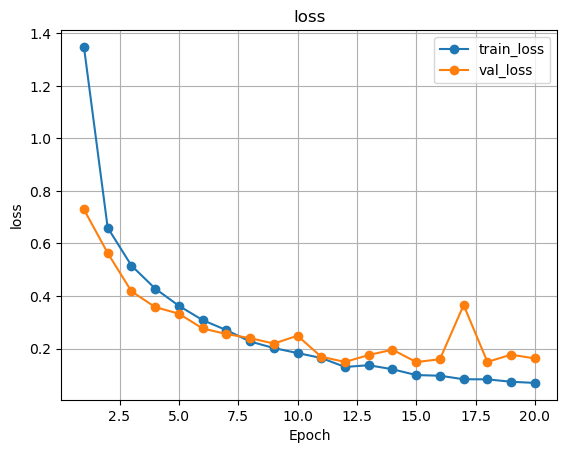

[INFO] Saved loss curve to results/plots/loss_curve.png


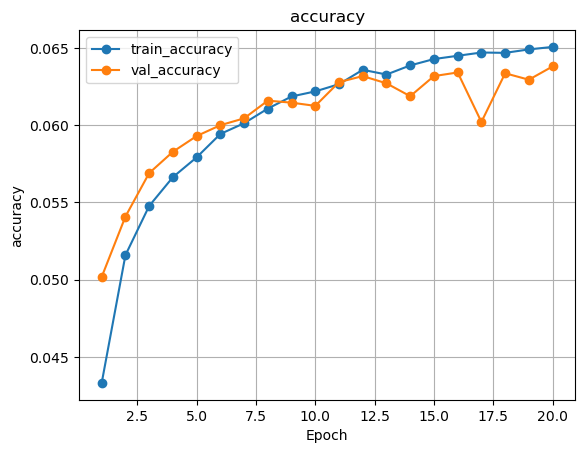

[INFO] Saved accuracy curve to results/plots/accuracy_curve.png


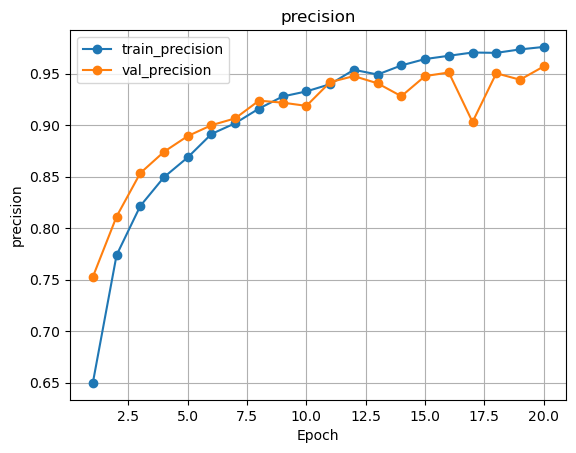

[INFO] Saved precision curve to results/plots/precision_curve.png


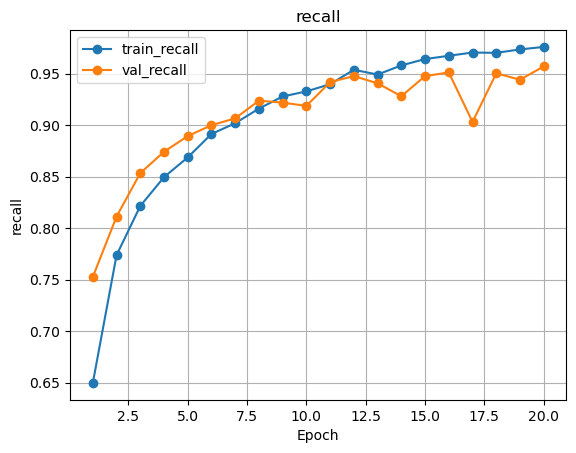

[INFO] Saved recall curve to results/plots/recall_curve.png


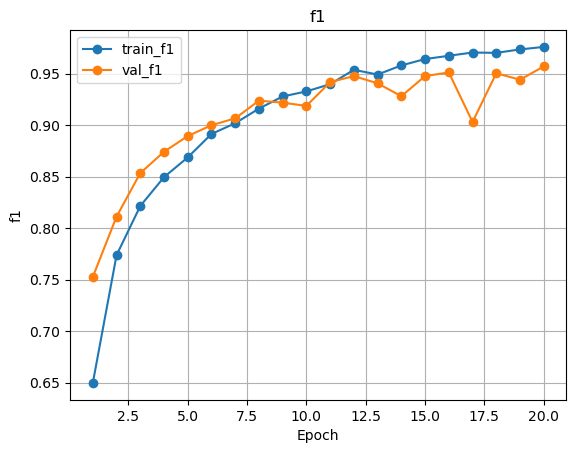

[INFO] Saved f1 curve to results/plots/f1_curve.png


In [12]:

plot_epoch_curves(history)

In [20]:
from pathlib import Path
import os
import json
from math import ceil

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [21]:

DATA_ROOT = Path("data/MangoAugmented_split")
RESULTS_DIR = Path("results")
CHECKPOINT_DIR = RESULTS_DIR / "checkpoints"
PLOTS_DIR = RESULTS_DIR / "plots"
FEATURE_MAP_DIR = RESULTS_DIR / "feature_maps"
FILTER_DIR = RESULTS_DIR / "filters"
PRED_DIR = RESULTS_DIR / "predictions"

IMG_SIZE = 256
BATCH_SIZE = 8

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_WORKERS = max(1, os.cpu_count() // 2)

In [22]:

for d in [RESULTS_DIR, PLOTS_DIR, FEATURE_MAP_DIR, FILTER_DIR, PRED_DIR]:
    d.mkdir(parents=True, exist_ok=True)


In [23]:

class CustomCNN(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * (IMG_SIZE // 16) * (IMG_SIZE // 16), 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [24]:

def compute_confusion_matrix(preds: torch.Tensor, targets: torch.Tensor, num_classes: int) -> torch.Tensor:
    cm = torch.zeros(num_classes, num_classes, dtype=torch.int64, device=targets.device)
    for t, p in zip(targets.view(-1), preds.view(-1)):
        cm[t.long(), p.long()] += 1
    return cm


def compute_metrics(cm: torch.Tensor) -> dict:
    eps = 1e-8
    tp_per_class = torch.diag(cm)
    tp = tp_per_class.sum().item()
    fp = (cm.sum(dim=0) - tp_per_class).sum().item()
    fn = (cm.sum(dim=1) - tp_per_class).sum().item()
    tn = (cm.sum() - cm.sum(dim=0) - cm.sum(dim=1) + tp_per_class).sum().item()

    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    f1 = 2 * precision * recall / (precision + recall + eps) if (precision + recall) > 0 else 0.0
    acc = tp / (tp + fn + fp + tn + eps)

    # per-class
    per_class = []
    num_classes = cm.size(0)
    total_samples = cm.sum().item()
    for c in range(num_classes):
        tp_c = cm[c, c].item()
        fp_c = (cm[:, c].sum() - cm[c, c]).item()
        fn_c = (cm[c, :].sum() - cm[c, c]).item()
        tn_c = (total_samples - tp_c - fp_c - fn_c)
        prec_c = tp_c / (tp_c + fp_c + eps)
        rec_c = tp_c / (tp_c + fn_c + eps)
        f1_c = 2 * prec_c * rec_c / (prec_c + rec_c + eps) if (prec_c + rec_c) > 0 else 0.0
        per_class.append({
            "tp": tp_c,
            "tn": tn_c,
            "fp": fp_c,
            "fn": fn_c,
            "precision": prec_c,
            "recall": rec_c,
            "f1": f1_c,
        })

    return {
        "global": {
            "accuracy": acc,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "tp": tp,
            "tn": tn,
            "fp": fp,
            "fn": fn,
        },
        "per_class": per_class,
    }


In [25]:

def get_test_loader(mean, std):
    tfms = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
    test_dir = DATA_ROOT / "test"
    test_ds = datasets.ImageFolder(test_dir, transform=tfms)
    loader = DataLoader(
        test_ds,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )
    return loader, test_ds.classes


def denormalize(img_tensor: torch.Tensor, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    img = img_tensor * std + mean
    img = img.clamp(0, 1)
    return img


def plot_confusion_matrix(cm: torch.Tensor, class_names, out_path: Path):
    cm_np = cm.cpu().numpy()
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(cm_np, interpolation="nearest")
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(cm_np.shape[1]),
        yticks=np.arange(cm_np.shape[0]),
        xticklabels=class_names,
        yticklabels=class_names,
        ylabel="True label",
        xlabel="Predicted label",
        title="Confusion Matrix",
    )
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    thresh = cm_np.max() / 2.0
    for i in range(cm_np.shape[0]):
        for j in range(cm_np.shape[1]):
            ax.text(
                j, i, format(cm_np[i, j], "d"),
                ha="center", va="center",
                color="white" if cm_np[i, j] > thresh else "black",
            )
    fig.tight_layout()
    fig.savefig(out_path, bbox_inches="tight")
    plt.show(fig)


def visualize_predictions(model, loader, class_names, mean, std, out_path: Path, num_samples: int = 32):
    model.eval()
    images_list = []
    true_list = []
    pred_list = []

    with torch.no_grad():
        for images, targets in loader:
            images = images.to(DEVICE)
            outputs = model(images)
            preds = outputs.argmax(dim=1).cpu()
            for img, t, p in zip(images.cpu(), targets, preds):
                images_list.append(img)
                true_list.append(t.item())
                pred_list.append(p.item())
                if len(images_list) >= num_samples:
                    break
            if len(images_list) >= num_samples:
                break

    num_samples = len(images_list)
    cols = 8
    rows = ceil(num_samples / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = np.array(axes).reshape(rows, cols)

    for idx in range(rows * cols):
        ax = axes[idx // cols, idx % cols]
        ax.axis("off")
        if idx >= num_samples:
            continue
        img = denormalize(images_list[idx], mean, std)
        img_np = img.permute(1, 2, 0).numpy()
        ax.imshow(img_np)
        true_name = class_names[true_list[idx]]
        pred_name = class_names[pred_list[idx]]
        correct = (true_list[idx] == pred_list[idx])
        color = "green" if correct else "red"
        ax.set_title(f"T:{true_name}\nP:{pred_name}", color=color, fontsize=8)

    fig.tight_layout()
    fig.savefig(out_path, bbox_inches="tight")
    plt.show(fig)


def get_conv_layers(model: nn.Module):
    conv_layers = []
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            conv_layers.append((name, module))
    return conv_layers


def save_feature_maps(model, loader, mean, std):
    conv_layers = get_conv_layers(model)
    feature_maps = {}

    def make_hook(name):
        def hook(module, inp, out):
            feature_maps[name] = out.detach().cpu()
        return hook

    handles = []
    for name, layer in conv_layers:
        handles.append(layer.register_forward_hook(make_hook(name)))

    # Run a single image through the network
    model.eval()
    images, _ = next(iter(loader))
    images = images.to(DEVICE)
    with torch.no_grad():
        _ = model(images[:1])

    for h in handles:
        h.remove()

    for name, fmap in feature_maps.items():
        fmap = fmap[0]  # first image: (C, H, W)
        num_channels = fmap.shape[0]
        cols = 8
        rows = ceil(num_channels / cols)
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 1.5, rows * 1.5))
        axes = np.array(axes).reshape(rows, cols)

        for idx in range(rows * cols):
            ax = axes[idx // cols, idx % cols]
            ax.axis("off")
            if idx >= num_channels:
                continue
            fm = fmap[idx]
            fm_np = fm.numpy()
            fm_np = (fm_np - fm_np.min()) / (fm_np.max() - fm_np.min() + 1e-8)
            ax.imshow(fm_np, cmap="viridis")

        fig.tight_layout()
        safe_name = name.replace(".", "_")
        out_path = FEATURE_MAP_DIR / f"{safe_name}_featuremaps.png"
        fig.savefig(out_path, bbox_inches="tight")
        plt.show(fig)
        print(f"[INFO] Saved feature maps for {name} to {out_path}")


def save_filters(model):
    conv_layers = get_conv_layers(model)
    for name, layer in conv_layers:
        weight = layer.weight.detach().cpu()  # (out_c, in_c, kH, kW)
        out_c, in_c, kH, kW = weight.shape
        cols = 8
        rows = ceil(out_c / cols)
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 1.5, rows * 1.5))
        axes = np.array(axes).reshape(rows, cols)

        for idx in range(rows * cols):
            ax = axes[idx // cols, idx % cols]
            ax.axis("off")
            if idx >= out_c:
                continue
            filt = weight[idx]
            if in_c == 3:
                filt_img = filt.permute(1, 2, 0).numpy()
            else:
                filt_img = filt.mean(dim=0).numpy()
            filt_img = (filt_img - filt_img.min()) / (filt_img.max() - filt_img.min() + 1e-8)
            if filt_img.ndim == 2:
                ax.imshow(filt_img, cmap="viridis")
            else:
                ax.imshow(filt_img)
        fig.tight_layout()
        safe_name = name.replace(".", "_")
        out_path = FILTER_DIR / f"{safe_name}_filters.png"
        fig.savefig(out_path, bbox_inches="tight")
        plt.show(fig)
        print(f"[INFO] Saved filters for {name} to {out_path}")


Eval [test]: 100%|██████████| 323/323 [00:02<00:00, 114.27it/s, loss=0.1688, acc=0.0641, f1=0.9609]


[INFO] Saved test metrics to results/test_metrics.json


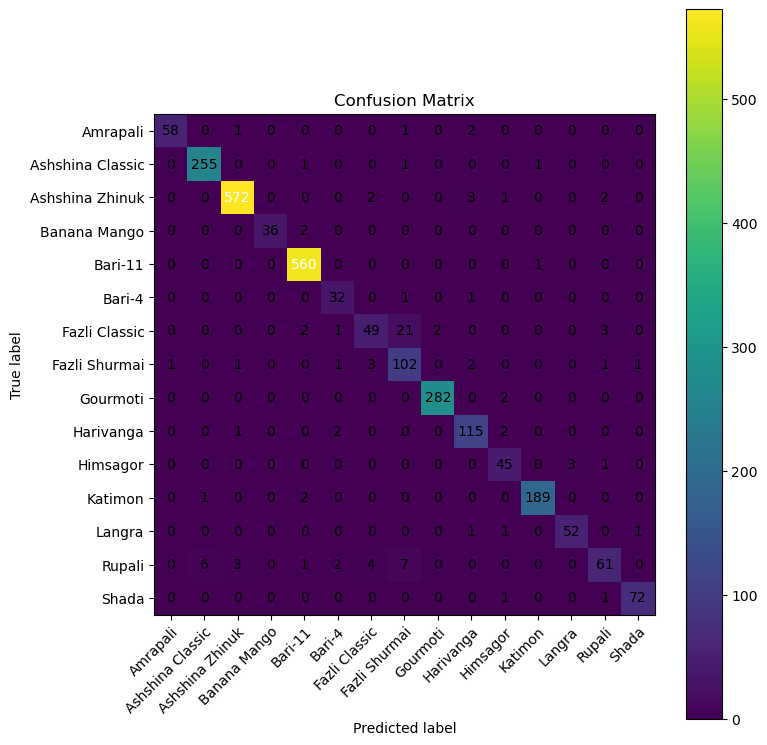

[INFO] Saved confusion matrix to results/plots/confusion_matrix.png


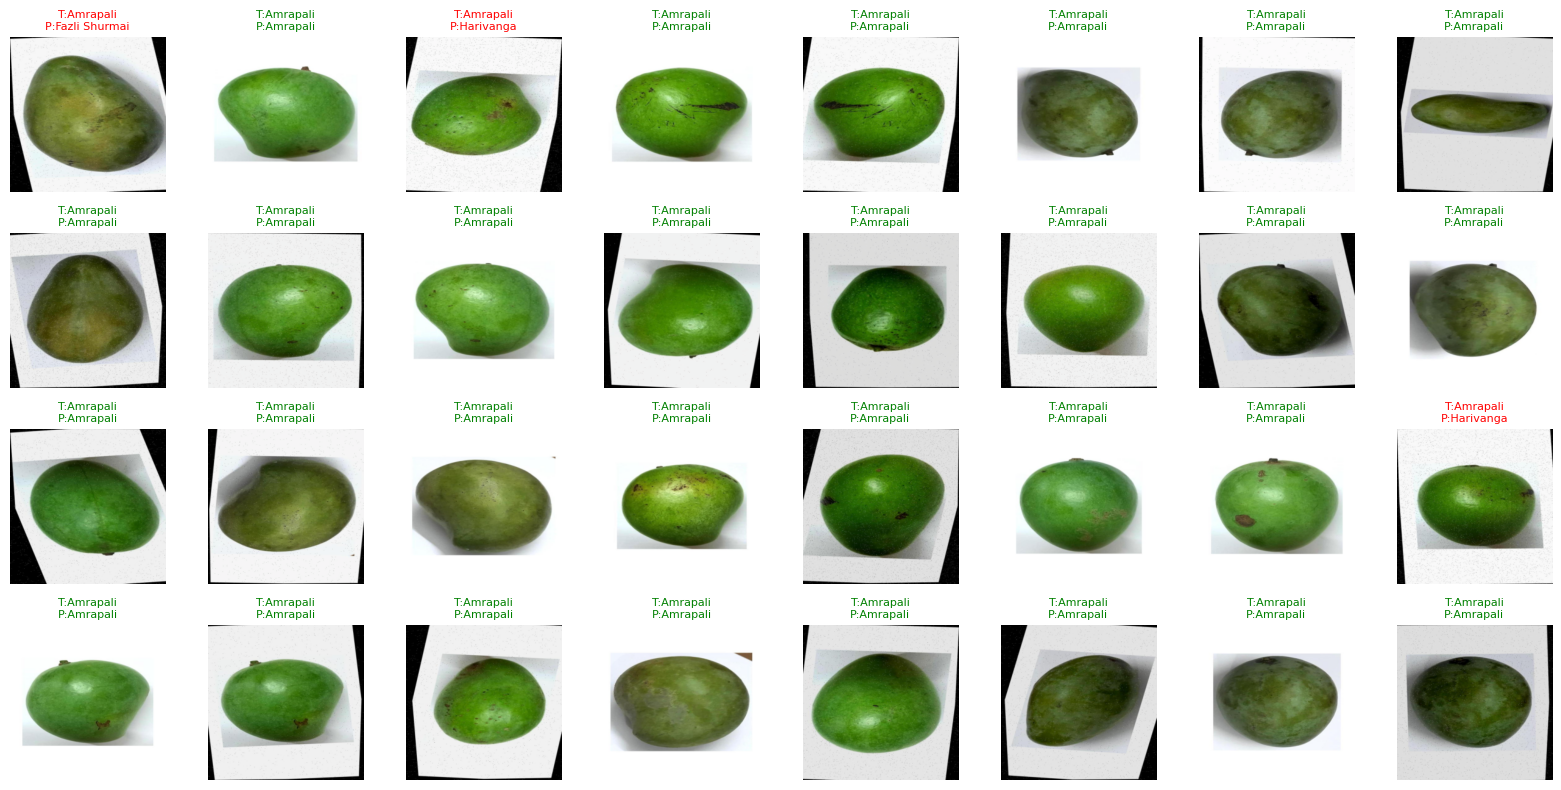

[INFO] Saved prediction grid to results/predictions/predictions_grid.png


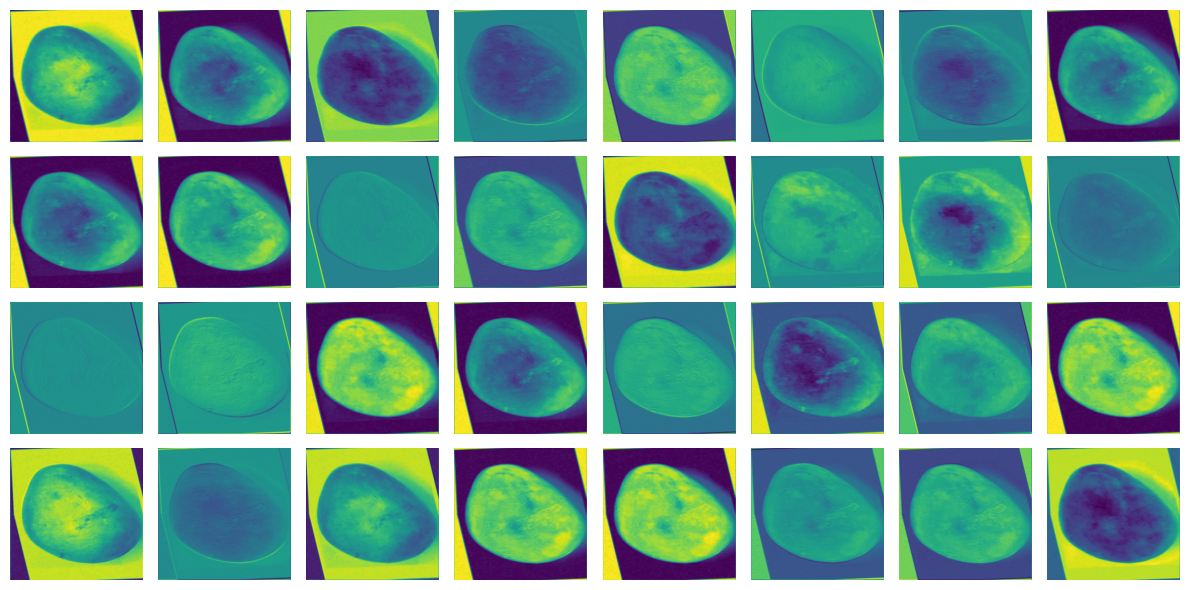

[INFO] Saved feature maps for features.0 to results/feature_maps/features_0_featuremaps.png


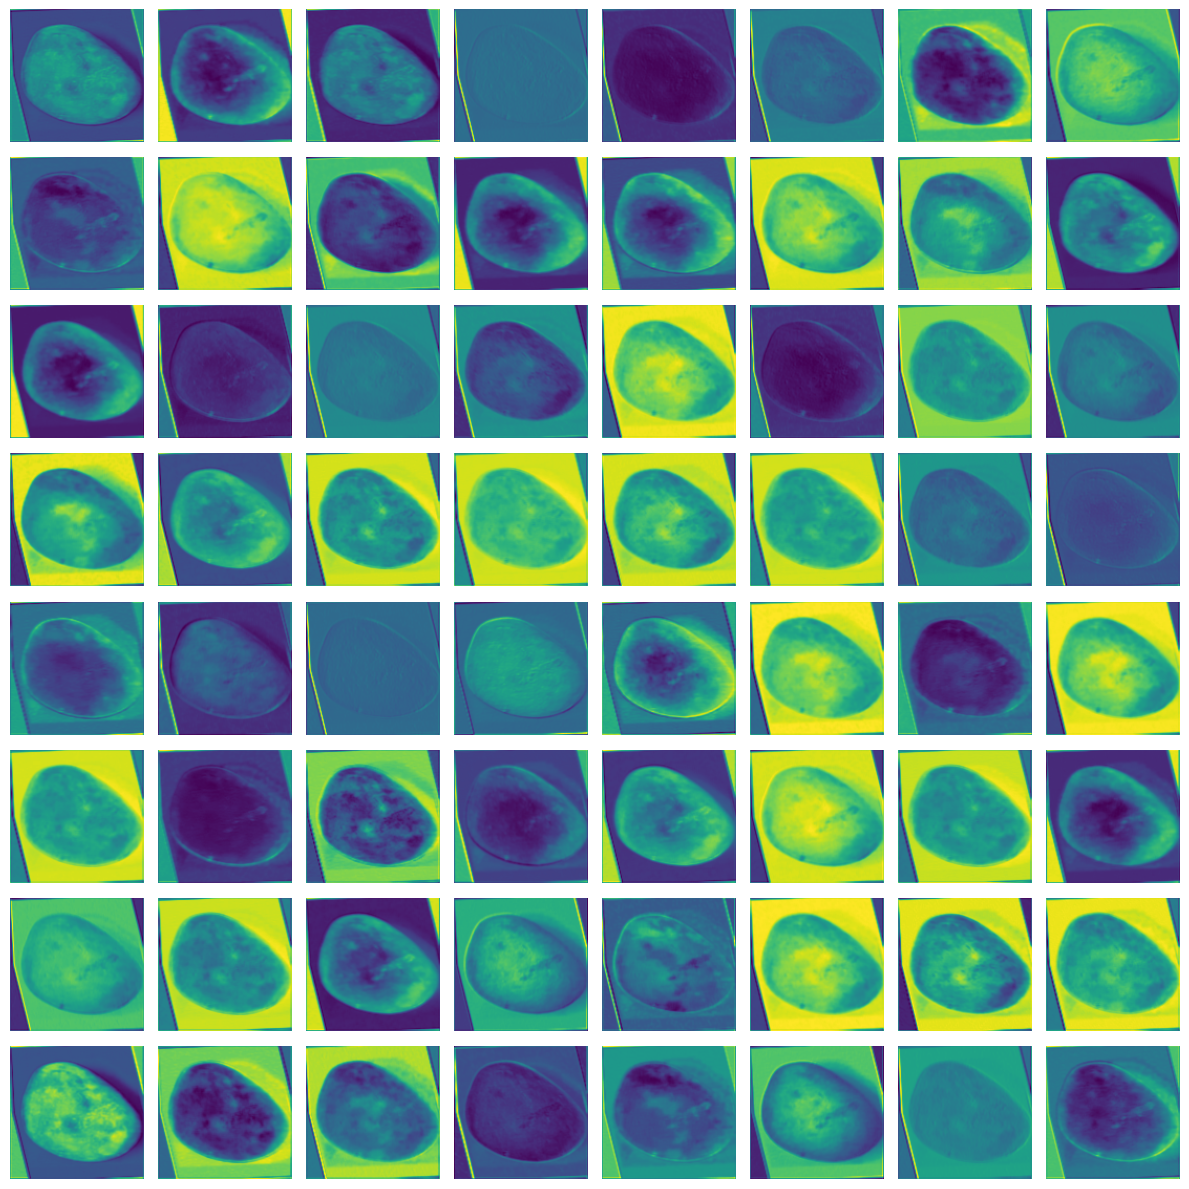

[INFO] Saved feature maps for features.4 to results/feature_maps/features_4_featuremaps.png


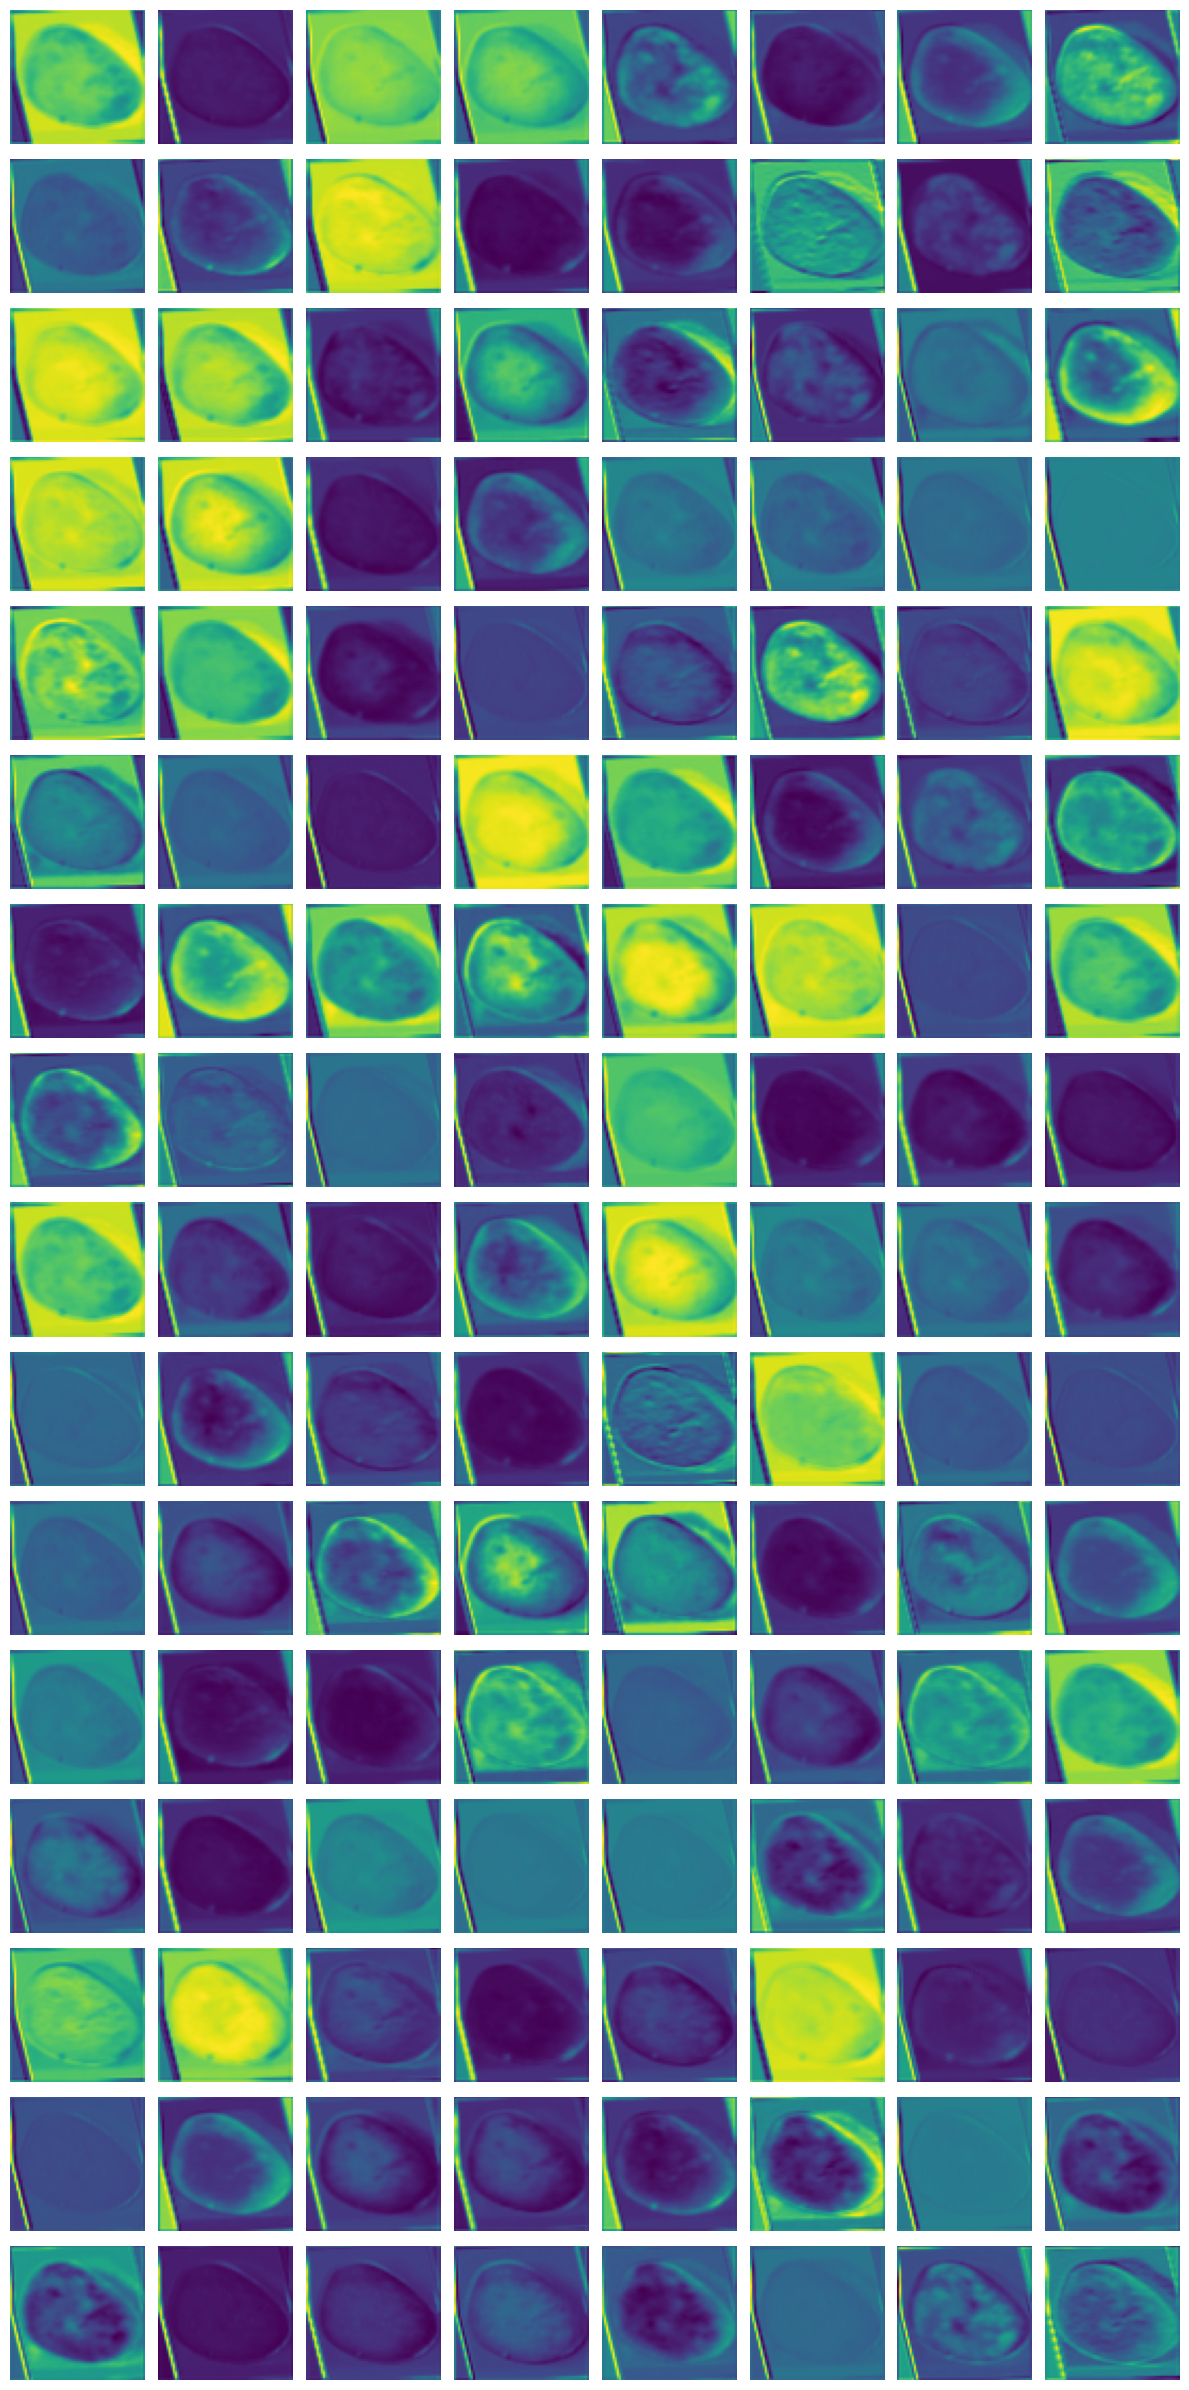

[INFO] Saved feature maps for features.8 to results/feature_maps/features_8_featuremaps.png


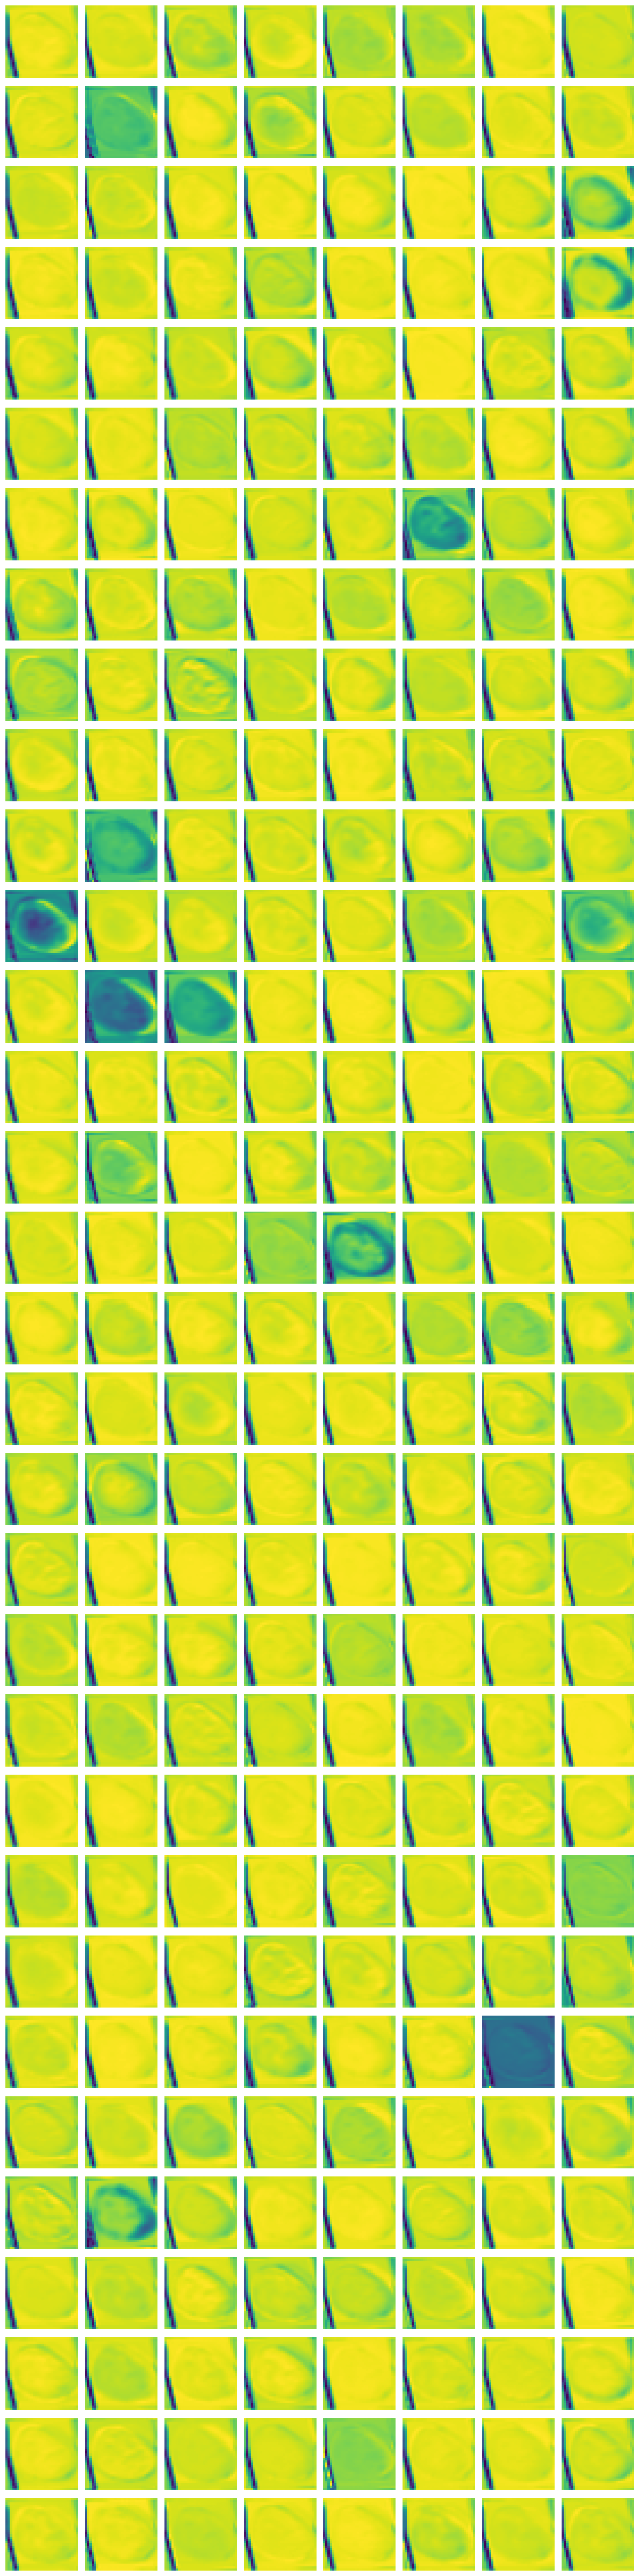

[INFO] Saved feature maps for features.12 to results/feature_maps/features_12_featuremaps.png


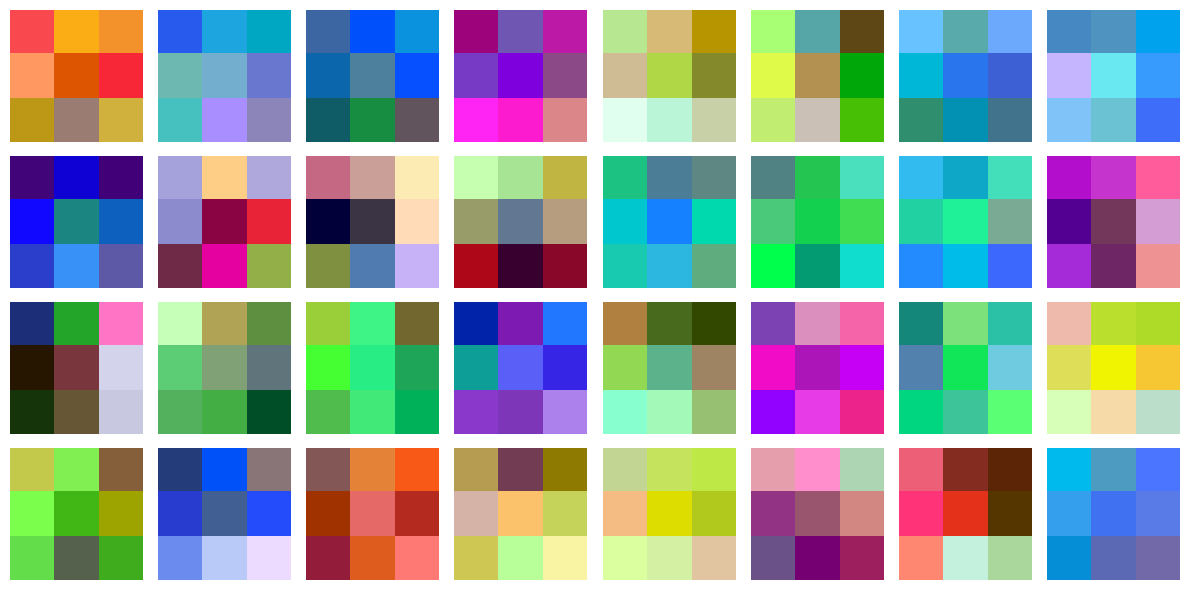

[INFO] Saved filters for features.0 to results/filters/features_0_filters.png


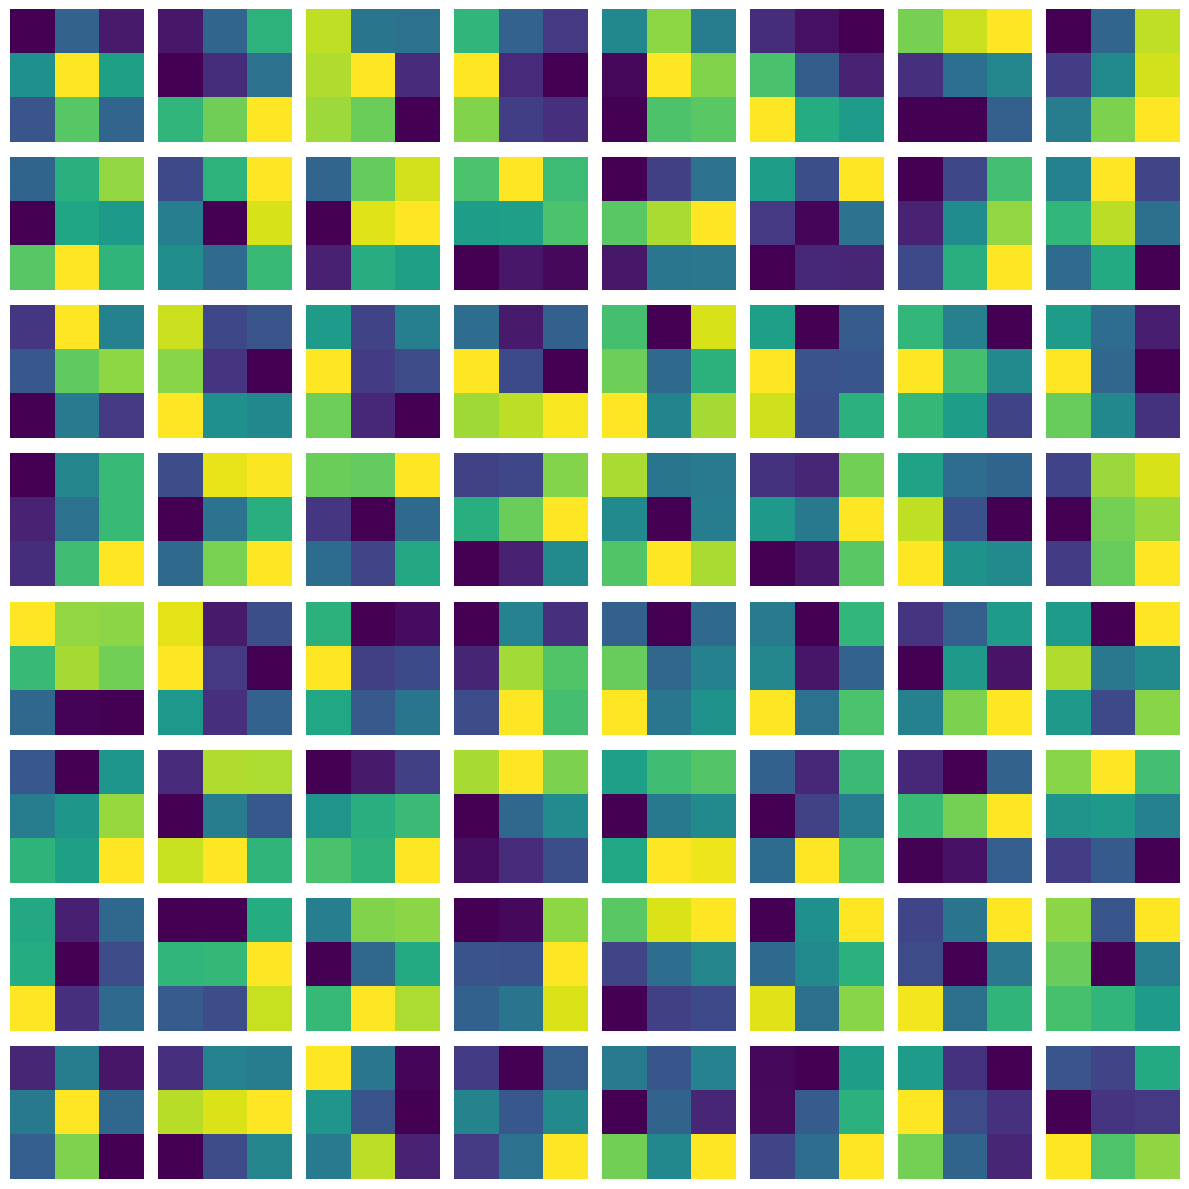

[INFO] Saved filters for features.4 to results/filters/features_4_filters.png


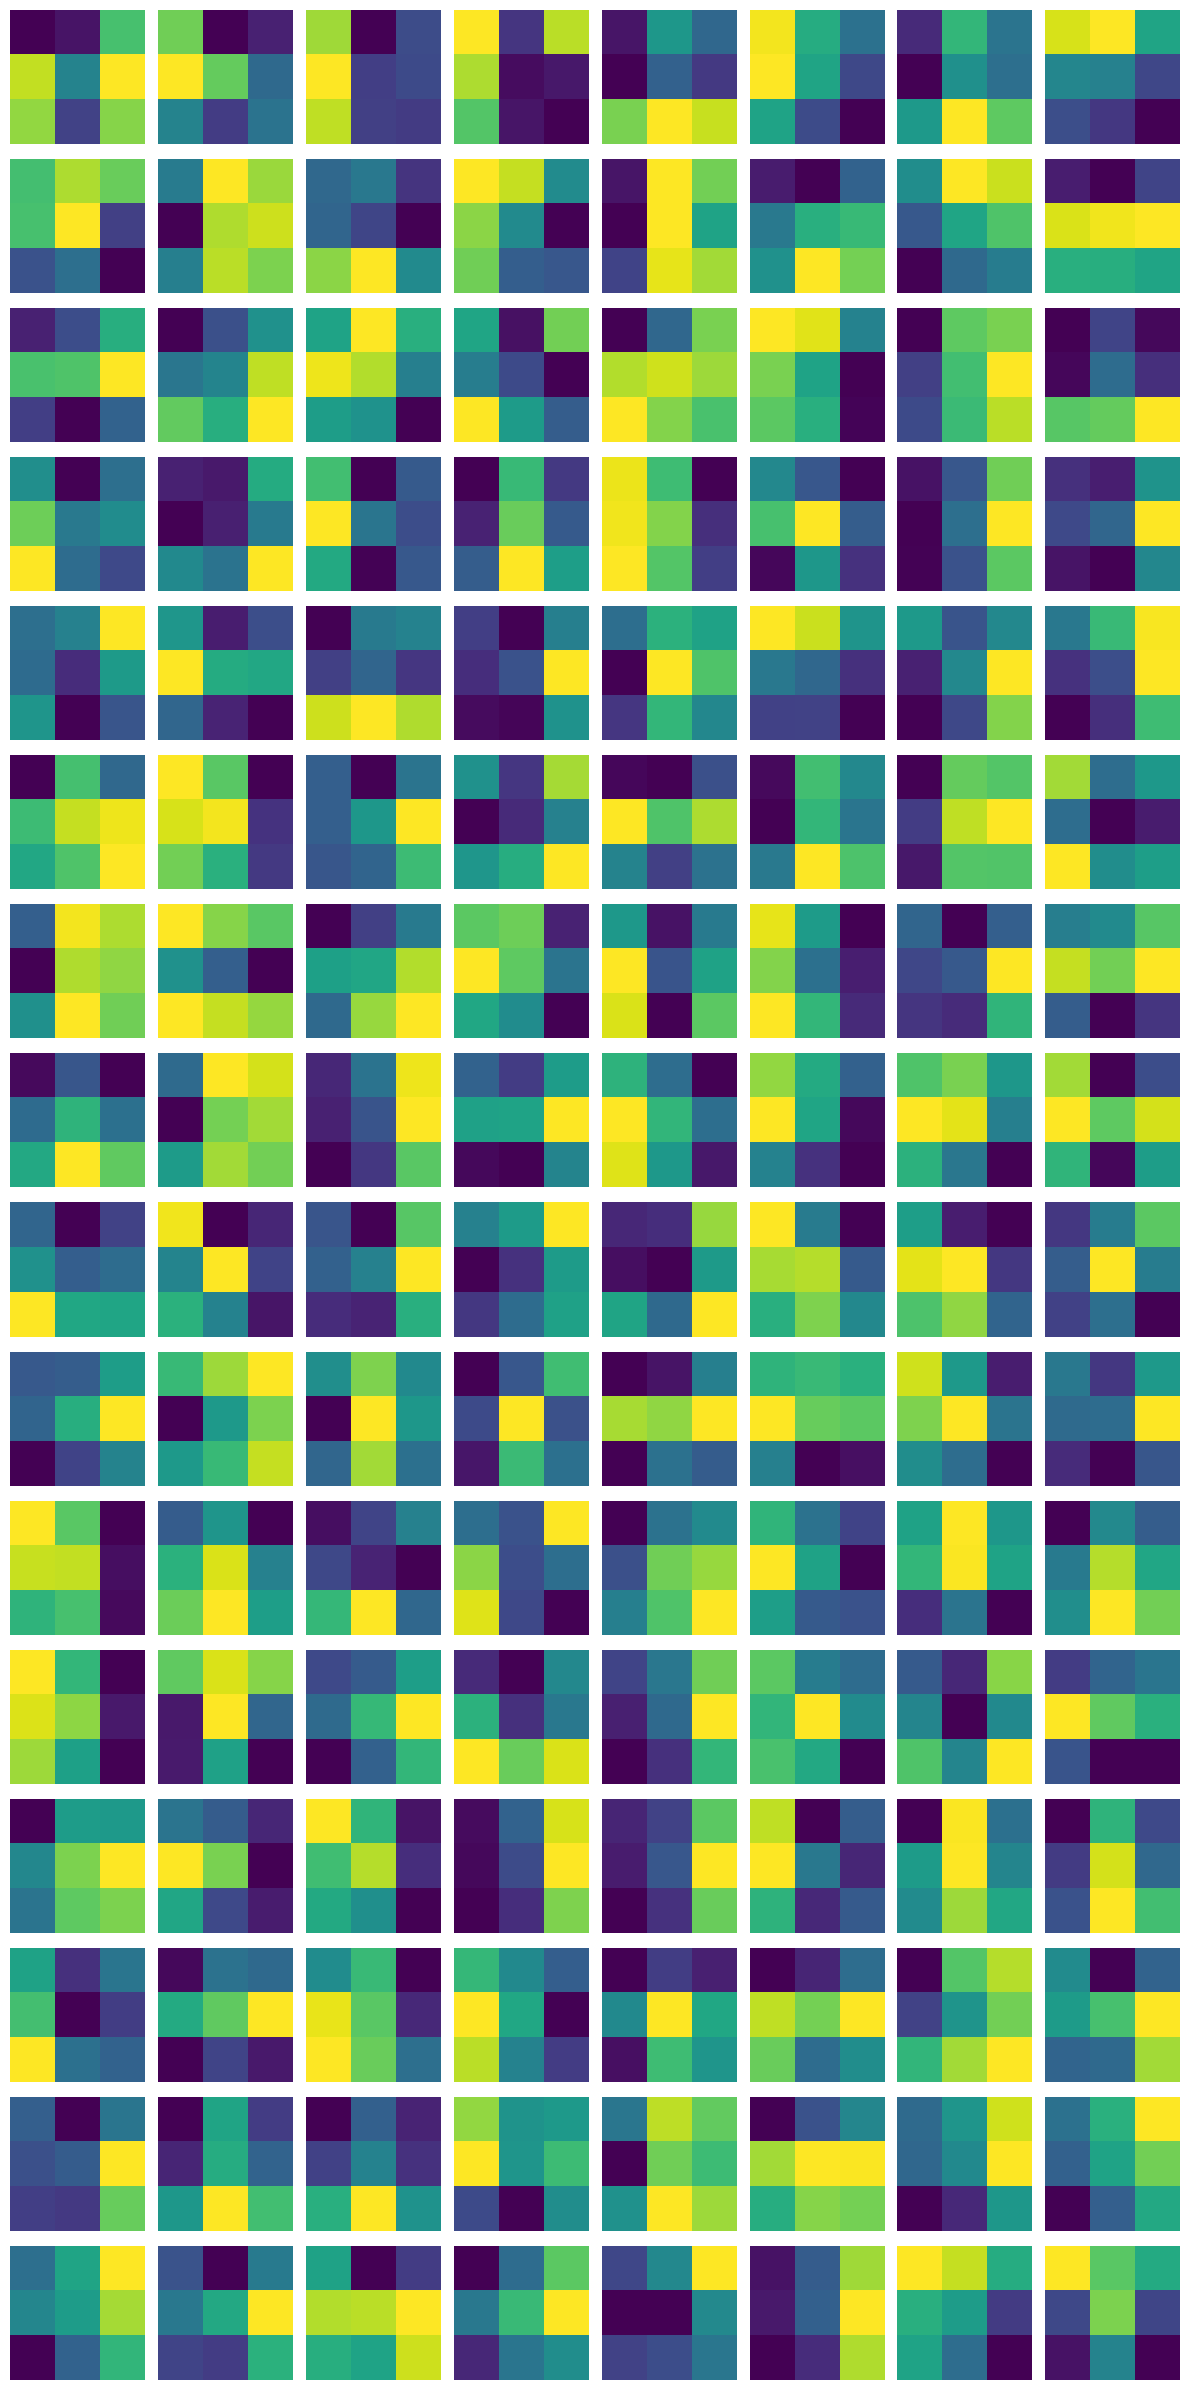

[INFO] Saved filters for features.8 to results/filters/features_8_filters.png


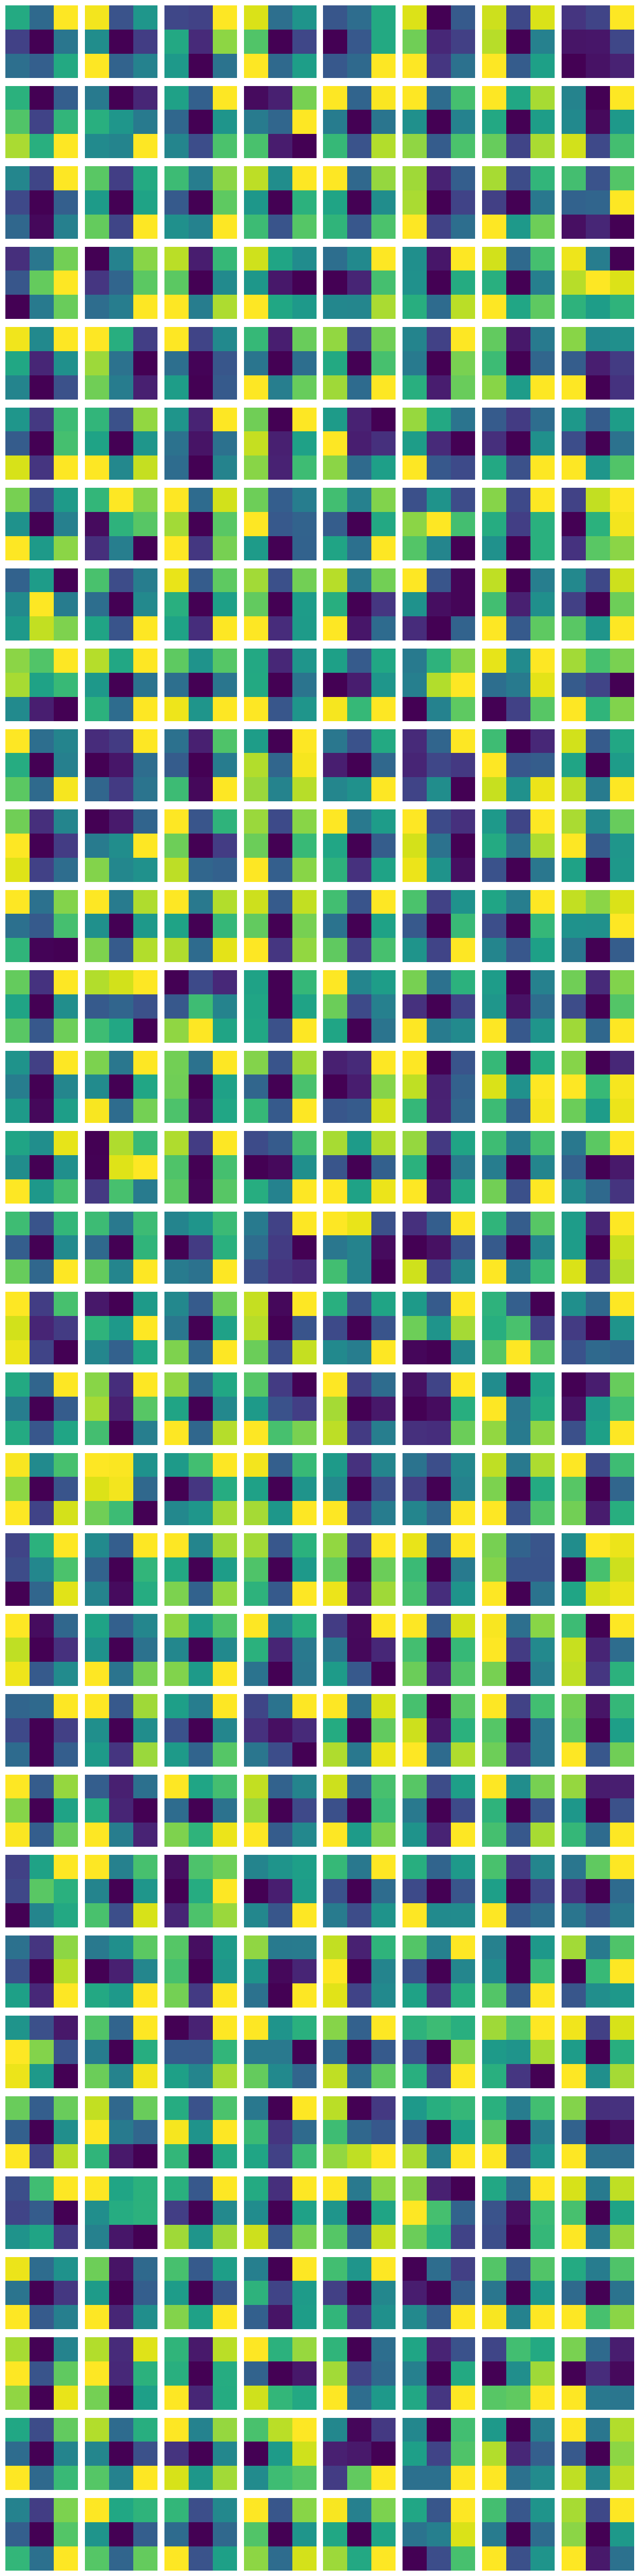

[INFO] Saved filters for features.12 to results/filters/features_12_filters.png


In [26]:

best_ckpt_path = CHECKPOINT_DIR / "best.pt"
if not best_ckpt_path.exists():
    raise FileNotFoundError(f"Best checkpoint not found at {best_ckpt_path}")

ckpt = torch.load(best_ckpt_path, map_location=DEVICE)
class_names = ckpt.get("class_names")
mean = ckpt.get("mean", [0.485, 0.456, 0.406])
std = ckpt.get("std", [0.229, 0.224, 0.225])

num_classes = len(class_names)
model = CustomCNN(num_classes=num_classes).to(DEVICE)
model.load_state_dict(ckpt["model_state"])

criterion = nn.CrossEntropyLoss()

test_loader, inferred_classes = get_test_loader(mean, std)
if class_names is None:
    class_names = inferred_classes

assert len(class_names) == len(inferred_classes), "Class names mismatch between training and test set."

model.eval()
total_loss = 0.0
total_samples = 0
cm_total = torch.zeros(len(class_names), len(class_names), dtype=torch.int64, device=DEVICE)

pbar = tqdm(test_loader, desc="Eval [test]")
with torch.no_grad():
    for images, targets in pbar:
        images, targets = images.to(DEVICE), targets.to(DEVICE)
        outputs = model(images)
        loss = criterion(outputs, targets)

        preds = outputs.argmax(dim=1)
        cm = compute_confusion_matrix(preds, targets, num_classes=len(class_names))
        cm_total += cm

        batch_size = targets.size(0)
        total_loss += loss.item() * batch_size
        total_samples += batch_size

        # live accuracy on tqdm
        metrics = compute_metrics(cm_total)["global"]
        avg_loss = total_loss / total_samples
        pbar.set_postfix({
            "loss": f"{avg_loss:.4f}",
            "acc": f"{metrics['accuracy']:.4f}",
            "f1": f"{metrics['f1']:.4f}",
        })

avg_loss = total_loss / total_samples
metrics_all = compute_metrics(cm_total)
metrics_all["global"]["loss"] = avg_loss
metrics_all["class_names"] = class_names

metrics_json_path = RESULTS_DIR / "test_metrics.json"
with metrics_json_path.open("w", encoding="utf-8") as f:
    json.dump(metrics_all, f, indent=2)
print(f"[INFO] Saved test metrics to {metrics_json_path}")

# Confusion matrix plot
cm_plot_path = PLOTS_DIR / "confusion_matrix.png"
plot_confusion_matrix(cm_total, class_names, cm_plot_path)
print(f"[INFO] Saved confusion matrix to {cm_plot_path}")

# Prediction grid – at least 32 predictions (if available)
pred_grid_path = PRED_DIR / "predictions_grid.png"
visualize_predictions(model, test_loader, class_names, mean, std, pred_grid_path, num_samples=32)
print(f"[INFO] Saved prediction grid to {pred_grid_path}")

# Feature maps and filters for the best model
save_feature_maps(model, test_loader, mean, std)
save_filters(model)
